https://precision.fda.gov/challenges/8
# PrecisionFDA
# Brain Cancer Predictive Modeling and Biomarker Discovery Challenge

An estimated 86,970 new cases of primary brain and other central nervous system tumors are expected to be diagnosed in the US in 2019. Brain tumors comprise a particularly deadly subset of all cancers due to limited treatment options and the high cost of care. Clinical investigators at Georgetown University are seeking to advance precision medicine techniques for the prognosis and treatment of brain tumors through the identification of novel multi-omics biomarkers. In support of this goal, precisionFDA and the Georgetown Lombardi Comprehensive Cancer Center and The Innovation Center for Biomedical Informatics at Georgetown University Medical Center (Georgetown-ICBI) are launching the Brain Cancer Predictive Modeling and Biomarker Discovery Challenge! This challenge will ask participants to develop machine learning and/or artificial intelligence models to identify biomarkers and predict patient outcomes using gene expression, DNA copy number, and clinical data.

## BACKGROUND
An estimated 86,970 new cases of primary brain and other central nervous system tumors are expected to be diagnosed in the US in 2019. Brain tumors comprise a particularly deadly subset of all cancers due to limited treatment options and the high cost of care. Only a few prognostic and predictive markers have been successfully implemented in the clinic so far for gliomas, the most common malignant brain tumor type. These markers include MGMT promoter methylation in high-grade astrocytomas, co-deletion of 1p/19q in oligodendrogliomas, and mutations in IDH1 or IDH2 genes (Staedtke et al. 2016). There remains significant potential for identifying new clinical biomarkers in gliomas.

Clinical investigators at Georgetown University are seeking to advance precision medicine techniques for the prognosis and treatment of brain tumors through the identification of novel multi-omics biomarkers. In support of this goal, precisionFDA and the Georgetown Lombardi Comprehensive Cancer Center and The Innovation Center for Biomedical Informatics at Georgetown University Medical Center are launching the Brain Cancer Predictive Modeling and Biomarker Discovery Challenge! This challenge asks participants to develop machine learning and/or artificial intelligence models to identify biomarkers and predict patient outcomes using gene expression, DNA copy number, and clinical data.

## CHALLENGE OVERVIEW
The Brain Cancer Predictive Modeling and Biomarker Discovery Challenge will launch on November 1, 2019 and end on February 1, 2020. Participants are asked to take part in three sub-challenges, which will be scored individually and combined for an overall challenge score. Participants will be provided DNA copy number data, gene expression profiles, clinical phenotypes, and outcomes for a cohort of patients in two phases. The Phase 1 data is the “provided” data that will be used to develop the models. Phase 2 data is the test data that will be used to score model performance. Phase 2 data will be released a week before the final deadline.

Participants are encouraged to utilize the phenotype data in addition to DNA copy number data and gene expression profiles for each sub-challenge. Participants are also encouraged to employ feature selection to minimize the features used while maintaining performance. A complete challenge submission will include predictions from each sub-challenge on the Phase 2 data, comprehensive documentation of methods employed and datasets used, and code developed for the challenge.

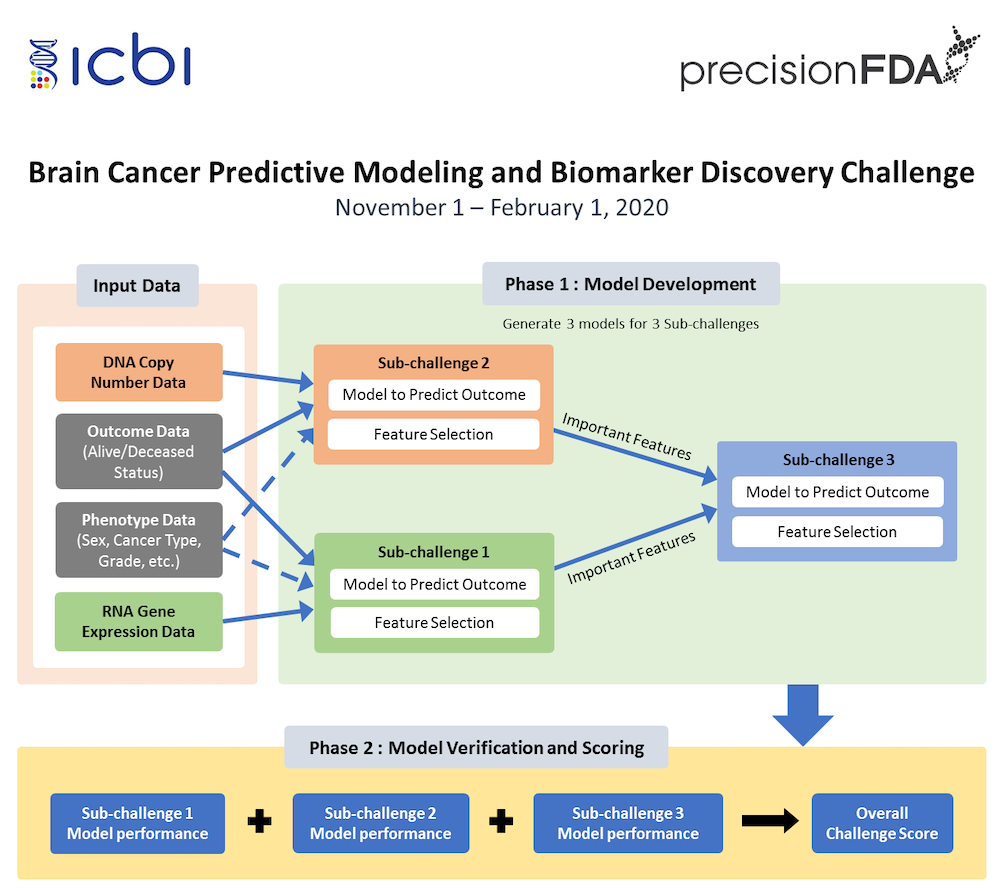

CHALLENGE DATA
Descriptions

* DNA copy number
 * Rows are samples
 * Columns are genomic cytobands
 * Values are reported as chromosome instability values (CIN Index) (Song et al. 2017) index values at the cytoband level. 0 indicates no instability
 * Source: SNP array
* Gene expression profiles
 * Rows are samples
 * Columns are gene names
 * Values are log2 normalized gene expression values
 * Source: microarray
* Survival status outcome
 * A value of 0 means the patient was alive or censoring at last follow up
 * A value of 1 means patient died before the last scheduled follow up
* Additional clinical phenotype data
 * Sex
 * Race
 * Cancer type*
 * WHO grading**
 
*Brain cancer types include:
* Astrocytoma - Originates in a particular kind of glial cells called astrocytes, star-shaped brain cells in the cerebrum. This type of tumor does not usually spread outside the brain and spinal cord; it usually does not affect other organs.
* GBM (glioblastoma) - The most aggressive cancer that begins within the brain. Glioblastomas represent 15% of brain tumors. They can either start from normal glial cells or develop from an existing low-grade astrocytoma.
* Oligodendroglioma - A tumor that can occur in the brain or spinal cord.  An oligodendroglioma tumor forms from oligodendrocytes — glial cells in the brain and spinal cord that produce myelin, a substance that protects nerve cells.
* Mixed - A tumor that has a mixed etiology.

**World Health Organization (WHO) grading is a measure of the “progressiveness” of central nervous system tumors:
* II - A group of abnormal slow growing cells that are found only in the place where they first formed in the body, are somewhat infiltrative, and may recur as a higher grade
* III - Malignant and infiltrative cells that tend to recur as a higher grade
* IV - The most malignant cells that experience rapid and aggressive growth and are widely infiltrative with rapid recurrence

Challenge timeline
* Phase 1
 * November 1, 2019: Phase 1 data released
 * January 22, 2020: Deadline for phase 1 submissions, which must include:
   * Phase 1 model summary
   * Phase 1 data used
* Phase 2
 * January 24, 2020: Phase 2 data released
   * Participants are expected to apply the models they have built using Phase 1 data to the Phase 2 data using gene expression, copy number, and clinical phenotype data (the latter is optional). This is expected to be done only once to avoid overfitting.
 * February 1, 2020: Deadline for Phase 2 submissions, which must include:
   * Phase 2 model summary
   * Phase 2 sub-challenge 1 patient outcome predictions
   * Phase 2 sub-challenge 2 patient outcome predictions
   * Phase 2 sub-challenge 3 patient outcome predictions

sub-challenge2 は DNA copy number と Phenotype を基に Outcome (0 (alive or censoring) or 1 (died) ) を予測する

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
import xgboost as xgb
import lightgbm as lgb
%matplotlib inline

In [3]:
CN_df = pd.read_csv('PresicionFDA_phase1_data/sc2_Phase1_CN_FeatureMatrix.tsv', delimiter='\t')
PT_df = pd.read_csv('PresicionFDA_phase1_data/sc2_Phase1_CN_Phenotype.tsv', delimiter='\t')
OC_df = pd.read_csv('PresicionFDA_phase1_data/sc2_Phase1_CN_Outcome.tsv', delimiter='\t')

In [4]:
CN_df

,PATIENTID,1p36.33,1p36.32,1p36.31,1p36.23,1p36.22,1p36.21,1p36.13,1p36.12,1p36.11,...,22q11.22,22q11.23,22q12.1,22q12.2,22q12.3,22q13.1,22q13.2,22q13.31,22q13.32,22q13.33
0,patient_290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,patient_394,0.000000,1.754379,1.505748,1.935076,1.448549,1.253364,2.057036,1.682664,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,patient_81,0.000000,0.000000,0.628766,0.000000,0.624529,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.660530,0.631818,1.785078,1.358591,1.240261,0.901599,0.659092,0.000000,0.000000
3,patient_307,0.000000,0.726093,0.000000,0.880939,1.755415,1.475263,1.131310,0.000000,0.594254,...,0.00000,0.000000,0.000000,0.000000,1.380215,1.482663,0.590108,0.000000,0.000000,0.000000
4,patient_14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,patient_589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
170,patient_283,0.718368,0.760858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.66385,0.663850,0.663850,0.663850,0.663850,0.663850,0.663850,0.663850,0.663850,0.663850
171,patient_25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.645793,1.100631,0.686889,0.599830,1.506325,1.583497,1.057542,0.640634,0.640634
172,patient_658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
PT_df

,PATIENTID,SEX,RACE,WHO_GRADING,CANCER_TYPE
0,patient_290,,NaN,II,ASTROCYTOMA
1,patient_394,,NaN,NaN,GBM
2,patient_81,,NaN,III,ASTROCYTOMA
3,patient_307,,NaN,NaN,UNCLASSIFIED
4,patient_14,,NaN,NaN,GBM
...,...,...,...,...,...
169,patient_589,MALE,WHITE,III,ASTROCYTOMA
170,patient_283,MALE,WHITE,NaN,GBM
171,patient_25,MALE,WHITE,NaN,GBM
172,patient_658,MALE,WHITE,III,OLIGODENDROGLIOMA


In [8]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
predictions = []
truth = []
roc_scores = []
log_loss_scores = []
num_round =50
for train_index, val_index in kfold.split(CN_df):
    train_x = CN_df.iloc[train_index].drop(['PATIENTID'], axis=1)
    train_y = OC_df.iloc[train_index]['SURVIVAL_STATUS']
    val_x = CN_df.iloc[val_index].drop(['PATIENTID'], axis=1)
    val_y = OC_df.iloc[val_index]['SURVIVAL_STATUS']

    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(val_x, label=val_y)

    params = {'task':'train', 'objective':'binary', 'random_ state': 7}
    model = lgb.train(params, dtrain, num_round, valid_sets=dval)
    pred = model.predict(val_x)
    predictions.append(pred)
    truth.append(val_y)
    roc = roc_auc_score(val_y, pred)
    print(roc)
    roc_scores.append(roc)
    log_loss_scores.append(log_loss(val_y, pred))

[1]	valid_0's binary_logloss: 0.581179
[2]	valid_0's binary_logloss: 0.583153
[3]	valid_0's binary_logloss: 0.579564
[4]	valid_0's binary_logloss: 0.576891
[5]	valid_0's binary_logloss: 0.582859
[6]	valid_0's binary_logloss: 0.579292
[7]	valid_0's binary_logloss: 0.588944
[8]	valid_0's binary_logloss: 0.596575
[9]	valid_0's binary_logloss: 0.598351
[10]	valid_0's binary_logloss: 0.608025
[11]	valid_0's binary_logloss: 0.604078
[12]	valid_0's binary_logloss: 0.600971
[13]	valid_0's binary_logloss: 0.609452
[14]	valid_0's binary_logloss: 0.610595
[15]	valid_0's binary_logloss: 0.610426
[16]	valid_0's binary_logloss: 0.616022
[17]	valid_0's binary_logloss: 0.618595
[18]	valid_0's binary_logloss: 0.624951
[19]	valid_0's binary_logloss: 0.626966
[20]	valid_0's binary_logloss: 0.63373
[21]	valid_0's binary_logloss: 0.641638
[22]	valid_0's binary_logloss: 0.639596
[23]	valid_0's binary_logloss: 0.63763
[24]	valid_0's binary_logloss: 0.645589
[25]	valid_0's binary_logloss: 0.656746
[26]	valid_

0.6044444444444445


In [9]:
log_loss_scores

[0.758759442690636,
 0.7989373193915487,
 0.6262458724284192,
 0.5762723785528261,
 0.6658282471661913]

In [10]:
roc_scores

[0.4658119658119658,
 0.44017094017094016,
 0.648,
 0.560344827586207,
 0.6044444444444445]

## Try feature reduction

In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_2 = KFold(n_splits=5, shuffle=True, random_state=1)
for trainval_index, test_index in kfold.split(CN_df):
    roc_scores =[]
    models = []
    for train_index, val_index in kfold_2.split(trainval_index):
        train_x = CN_df.iloc[train_index].drop(['PATIENTID'], axis=1)
        train_y = OC_df.iloc[train_index]['SURVIVAL_STATUS']
        val_x = CN_df.iloc[val_index].drop(['PATIENTID'], axis=1)
        val_y = OC_df.iloc[val_index]['SURVIVAL_STATUS']

        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(val_x, label=val_y)

        params = {'task':'train', 'objective':'binary', 'random_ state': 7}
        model = lgb.train(params, dtrain, num_round, valid_sets=dval)
        pred = model.predict(val_x)
        predictions.append(pred)
        truth.append(val_y)
        roc = roc_auc_score(val_y, pred)
        print(roc)
        roc_scores.append(roc)
        models.append(model)

    importances = np.array([model.feature_importance('gain') for model in models])
#     important_index = (importances.mean(axis=0) > mean_importance_threshold) & (importances.std(axis=0)/importances.mean(axis=0) < std_per_mean_threshold)   
    
    break
#     print(np.mean(roc_scores_best), np.std(roc_scores_best))

[1]	valid_0's binary_logloss: 0.473118
[2]	valid_0's binary_logloss: 0.46231
[3]	valid_0's binary_logloss: 0.457144
[4]	valid_0's binary_logloss: 0.438724
[5]	valid_0's binary_logloss: 0.447314
[6]	valid_0's binary_logloss: 0.440419
[7]	valid_0's binary_logloss: 0.427275
[8]	valid_0's binary_logloss: 0.4357
[9]	valid_0's binary_logloss: 0.432049
[10]	valid_0's binary_logloss: 0.428983
[11]	valid_0's binary_logloss: 0.434528
[12]	valid_0's binary_logloss: 0.423166
[13]	valid_0's binary_logloss: 0.424704
[14]	valid_0's binary_logloss: 0.425654
[15]	valid_0's binary_logloss: 0.427338
[16]	valid_0's binary_logloss: 0.426001
[17]	valid_0's binary_logloss: 0.431992
[18]	valid_0's binary_logloss: 0.434113
[19]	valid_0's binary_logloss: 0.431171
[20]	valid_0's binary_logloss: 0.428012
[21]	valid_0's binary_logloss: 0.418641
[22]	valid_0's binary_logloss: 0.410789
[23]	valid_0's binary_logloss: 0.406412
[24]	valid_0's binary_logloss: 0.404197
[25]	valid_0's binary_logloss: 0.401399
[26]	valid_0

0.45714285714285713


In [12]:
mean_importances = np.mean(importances, axis=0)
std_importamces = np.std(importances, axis=0)

(array([  2.,   5.,   6.,  12.,   8.,  26.,  13.,  13.,   6., 109.]),
 array([0.34833158, 0.51349843, 0.67866527, 0.84383211, 1.00899895,
        1.17416579, 1.33933263, 1.50449948, 1.66966632, 1.83483316,
        2.        ]),
 <a list of 10 Patch objects>)

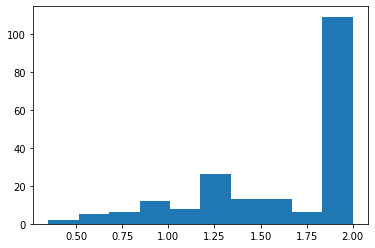

In [13]:
plt.hist(std_importamces[mean_importances != 0]/mean_importances[mean_importances!=0])

(array([753.,  38.,   8.,   3.,   3.,   1.,   1.,   2.,   1.,   1.]),
 array([ 0.        ,  2.5204535 ,  5.04090701,  7.56136051, 10.08181401,
        12.60226752, 15.12272102, 17.64317452, 20.16362803, 22.68408153,
        25.20453503]),
 <a list of 10 Patch objects>)

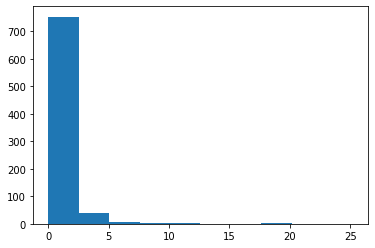

In [14]:
plt.hist(mean_importances)

(array([142.,  39.,   7.,   4.,   2.,   1.,   1.,   2.,   1.,   1.]),
 array([ 0.065575  ,  2.579471  ,  5.093367  ,  7.60726301, 10.12115901,
        12.63505501, 15.14895102, 17.66284702, 20.17674302, 22.69063903,
        25.20453503]),
 <a list of 10 Patch objects>)

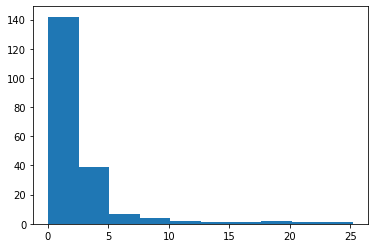

In [16]:
plt.hist(mean_importances[mean_importances>0.01])

In [21]:
mean_importance_threshold = 0.01
std_per_mean_threshold = 1.8
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
predictions = []
true_values = []
important_indexes = []
importances_in_folds = []
for trainval_index, test_index in kfold.split(CN_df):
    trainval_x = CN_df.iloc[trainval_index].drop(['PATIENTID'], axis=1).reset_index(drop=True)
    trainval_y = OC_df.iloc[trainval_index].drop(['PATIENTID'], axis=1)['SURVIVAL_STATUS'].reset_index(drop=True)
    roc_scores =[]
    models = []
    kfold_2 = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_index, val_index in kfold_2.split(trainval_x):
        train_x = trainval_x.iloc[train_index]
        train_y = trainval_y.iloc[train_index]
        val_x = trainval_x.iloc[val_index]
        val_y = trainval_y.iloc[val_index]

        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(val_x, label=val_y)

        params = {'task':'train', 'objective':'binary', 'random_ state': 7, 'verbosity':0}
        model = lgb.train(params, dtrain, num_round, valid_sets=dval)
        pred = model.predict(val_x)
        models.append(model)
    # get_importance from lgbm
    # select importance with lerger mean and smaller std/mean
    importances = np.array([model.feature_importance('gain') for model in models])
    important_index = ((importances.mean(axis=0)[importances.mean(axis=0) != 0] > mean_importance_threshold) &
                       ((importances.std(axis=0)[importances.mean(axis=0) != 0])
                        /(importances.mean(axis=0)[importances.mean(axis=0) != 0]) < std_per_mean_threshold))
    print('feature length = ', np.sum(important_index))
    importances_in_folds.append(importances)
    important_indexes.append(important_index)
    # re-train with selected feature
    kfold_2 = KFold(n_splits=5, shuffle=True, random_state=1)
    models = []
    for train_index, val_index in kfold_2.split(trainval_x):
        train_x = trainval_x.iloc[train_index]
        train_y = trainval_y.iloc[train_index]
        val_x = trainval_x.iloc[val_index]
        val_y = trainval_y.iloc[val_index]
        
        train_x = train_x.iloc[:, importances.mean(axis=0) != 0]
        train_x = train_x.iloc[:, important_index] 
        val_x = val_x.iloc[:, importances.mean(axis=0) != 0]
        val_x = val_x.iloc[:, important_index]

        # train and val xgboost
        dtrain = lgb.Dataset(train_x, train_y)
        dval = lgb.Dataset(val_x, val_y)
        params = {'task':'train', 'objective':'binary', 'random_ state': 7}
        model = lgb.train(params, dtrain, num_round, valid_sets=dval)
        models.append(model)
    
    test_x = CN_df.iloc[test_index].drop(['PATIENTID'], axis=1)
    test_x = test_x.iloc[:, importances.mean(axis=0) != 0]
    test_x = test_x.iloc[:, important_index]
    test_y = OC_df.iloc[test_index]['SURVIVAL_STATUS']
    dtest = lgb.Dataset(test_x, test_y)
    
    pred = [model.predict(test_x) for model in models]
    pred = np.array(pred)
    pred = np.mean(pred, axis=0)
    predictions.append(pred)
    true_values.append(test_y)

[1]	valid_0's binary_logloss: 0.639807
[2]	valid_0's binary_logloss: 0.631143
[3]	valid_0's binary_logloss: 0.63434
[4]	valid_0's binary_logloss: 0.638289
[5]	valid_0's binary_logloss: 0.656674
[6]	valid_0's binary_logloss: 0.651775
[7]	valid_0's binary_logloss: 0.639489
[8]	valid_0's binary_logloss: 0.623902
[9]	valid_0's binary_logloss: 0.625489
[10]	valid_0's binary_logloss: 0.633721
[11]	valid_0's binary_logloss: 0.646722
[12]	valid_0's binary_logloss: 0.641725
[13]	valid_0's binary_logloss: 0.638165
[14]	valid_0's binary_logloss: 0.63846
[15]	valid_0's binary_logloss: 0.648221
[16]	valid_0's binary_logloss: 0.647435
[17]	valid_0's binary_logloss: 0.646975
[18]	valid_0's binary_logloss: 0.659025
[19]	valid_0's binary_logloss: 0.655146
[20]	valid_0's binary_logloss: 0.659183
[21]	valid_0's binary_logloss: 0.6681
[22]	valid_0's binary_logloss: 0.666501
[23]	valid_0's binary_logloss: 0.677718
[24]	valid_0's binary_logloss: 0.680749
[25]	valid_0's binary_logloss: 0.67938
[26]	valid_0's

[43]	valid_0's binary_logloss: 0.587747
[44]	valid_0's binary_logloss: 0.579981
[45]	valid_0's binary_logloss: 0.575536
[46]	valid_0's binary_logloss: 0.57998
[47]	valid_0's binary_logloss: 0.58657
[48]	valid_0's binary_logloss: 0.587198
[49]	valid_0's binary_logloss: 0.590864
[50]	valid_0's binary_logloss: 0.593054
feature length =  69
[1]	valid_0's binary_logloss: 0.639807
[2]	valid_0's binary_logloss: 0.623344
[3]	valid_0's binary_logloss: 0.6291
[4]	valid_0's binary_logloss: 0.628663
[5]	valid_0's binary_logloss: 0.645049
[6]	valid_0's binary_logloss: 0.641542
[7]	valid_0's binary_logloss: 0.644657
[8]	valid_0's binary_logloss: 0.647356
[9]	valid_0's binary_logloss: 0.63633
[10]	valid_0's binary_logloss: 0.638591
[11]	valid_0's binary_logloss: 0.635221
[12]	valid_0's binary_logloss: 0.638344
[13]	valid_0's binary_logloss: 0.647929
[14]	valid_0's binary_logloss: 0.650057
[15]	valid_0's binary_logloss: 0.649844
[16]	valid_0's binary_logloss: 0.644779
[17]	valid_0's binary_logloss: 0.

[4]	valid_0's binary_logloss: 0.531716
[5]	valid_0's binary_logloss: 0.531264
[6]	valid_0's binary_logloss: 0.521201
[7]	valid_0's binary_logloss: 0.524794
[8]	valid_0's binary_logloss: 0.517075
[9]	valid_0's binary_logloss: 0.506968
[10]	valid_0's binary_logloss: 0.499962
[11]	valid_0's binary_logloss: 0.504154
[12]	valid_0's binary_logloss: 0.502956
[13]	valid_0's binary_logloss: 0.496919
[14]	valid_0's binary_logloss: 0.496413
[15]	valid_0's binary_logloss: 0.496529
[16]	valid_0's binary_logloss: 0.49447
[17]	valid_0's binary_logloss: 0.502822
[18]	valid_0's binary_logloss: 0.507124
[19]	valid_0's binary_logloss: 0.499718
[20]	valid_0's binary_logloss: 0.496929
[21]	valid_0's binary_logloss: 0.493418
[22]	valid_0's binary_logloss: 0.488478
[23]	valid_0's binary_logloss: 0.483687
[24]	valid_0's binary_logloss: 0.490581
[25]	valid_0's binary_logloss: 0.494409
[26]	valid_0's binary_logloss: 0.491093
[27]	valid_0's binary_logloss: 0.492048
[28]	valid_0's binary_logloss: 0.492155
[29]	va

[1]	valid_0's binary_logloss: 0.503855
[2]	valid_0's binary_logloss: 0.509848
[3]	valid_0's binary_logloss: 0.514946
[4]	valid_0's binary_logloss: 0.522361
[5]	valid_0's binary_logloss: 0.530083
[6]	valid_0's binary_logloss: 0.53545
[7]	valid_0's binary_logloss: 0.534764
[8]	valid_0's binary_logloss: 0.519832
[9]	valid_0's binary_logloss: 0.528643
[10]	valid_0's binary_logloss: 0.54119
[11]	valid_0's binary_logloss: 0.551007
[12]	valid_0's binary_logloss: 0.549034
[13]	valid_0's binary_logloss: 0.566144
[14]	valid_0's binary_logloss: 0.579668
[15]	valid_0's binary_logloss: 0.57661
[16]	valid_0's binary_logloss: 0.585468
[17]	valid_0's binary_logloss: 0.59739
[18]	valid_0's binary_logloss: 0.598247
[19]	valid_0's binary_logloss: 0.606985
[20]	valid_0's binary_logloss: 0.600499
[21]	valid_0's binary_logloss: 0.606039
[22]	valid_0's binary_logloss: 0.616087
[23]	valid_0's binary_logloss: 0.622748
[24]	valid_0's binary_logloss: 0.622574
[25]	valid_0's binary_logloss: 0.622582
[26]	valid_0'

[19]	valid_0's binary_logloss: 0.560947
[20]	valid_0's binary_logloss: 0.561188
[21]	valid_0's binary_logloss: 0.568244
[22]	valid_0's binary_logloss: 0.562113
[23]	valid_0's binary_logloss: 0.565207
[24]	valid_0's binary_logloss: 0.570913
[25]	valid_0's binary_logloss: 0.571189
[26]	valid_0's binary_logloss: 0.575193
[27]	valid_0's binary_logloss: 0.569278
[28]	valid_0's binary_logloss: 0.56334
[29]	valid_0's binary_logloss: 0.559691
[30]	valid_0's binary_logloss: 0.55595
[31]	valid_0's binary_logloss: 0.562688
[32]	valid_0's binary_logloss: 0.561507
[33]	valid_0's binary_logloss: 0.560751
[34]	valid_0's binary_logloss: 0.56312
[35]	valid_0's binary_logloss: 0.563736
[36]	valid_0's binary_logloss: 0.559629
[37]	valid_0's binary_logloss: 0.555164
[38]	valid_0's binary_logloss: 0.556778
[39]	valid_0's binary_logloss: 0.552676
[40]	valid_0's binary_logloss: 0.549985
[41]	valid_0's binary_logloss: 0.547945
[42]	valid_0's binary_logloss: 0.555382
[43]	valid_0's binary_logloss: 0.553189
[44

[1]	valid_0's binary_logloss: 0.551502
[2]	valid_0's binary_logloss: 0.572219
[3]	valid_0's binary_logloss: 0.583958
[4]	valid_0's binary_logloss: 0.576792
[5]	valid_0's binary_logloss: 0.59178
[6]	valid_0's binary_logloss: 0.589962
[7]	valid_0's binary_logloss: 0.593694
[8]	valid_0's binary_logloss: 0.604536
[9]	valid_0's binary_logloss: 0.613763
[10]	valid_0's binary_logloss: 0.612468
[11]	valid_0's binary_logloss: 0.61627
[12]	valid_0's binary_logloss: 0.624587
[13]	valid_0's binary_logloss: 0.629184
[14]	valid_0's binary_logloss: 0.631689
[15]	valid_0's binary_logloss: 0.633965
[16]	valid_0's binary_logloss: 0.641388
[17]	valid_0's binary_logloss: 0.637814
[18]	valid_0's binary_logloss: 0.6439
[19]	valid_0's binary_logloss: 0.649397
[20]	valid_0's binary_logloss: 0.659169
[21]	valid_0's binary_logloss: 0.657604
[22]	valid_0's binary_logloss: 0.661054
[23]	valid_0's binary_logloss: 0.664991
[24]	valid_0's binary_logloss: 0.671383
[25]	valid_0's binary_logloss: 0.68275
[26]	valid_0's

[9]	valid_0's binary_logloss: 0.397891
[10]	valid_0's binary_logloss: 0.398125
[11]	valid_0's binary_logloss: 0.405703
[12]	valid_0's binary_logloss: 0.405354
[13]	valid_0's binary_logloss: 0.408827
[14]	valid_0's binary_logloss: 0.400928
[15]	valid_0's binary_logloss: 0.407237
[16]	valid_0's binary_logloss: 0.405606
[17]	valid_0's binary_logloss: 0.406257
[18]	valid_0's binary_logloss: 0.412296
[19]	valid_0's binary_logloss: 0.414969
[20]	valid_0's binary_logloss: 0.411651
[21]	valid_0's binary_logloss: 0.412466
[22]	valid_0's binary_logloss: 0.413681
[23]	valid_0's binary_logloss: 0.4124
[24]	valid_0's binary_logloss: 0.418357
[25]	valid_0's binary_logloss: 0.419921
[26]	valid_0's binary_logloss: 0.423101
[27]	valid_0's binary_logloss: 0.418276
[28]	valid_0's binary_logloss: 0.416942
[29]	valid_0's binary_logloss: 0.412585
[30]	valid_0's binary_logloss: 0.415945
[31]	valid_0's binary_logloss: 0.422539
[32]	valid_0's binary_logloss: 0.424851
[33]	valid_0's binary_logloss: 0.420108
[34

[1]	valid_0's binary_logloss: 0.460231
[2]	valid_0's binary_logloss: 0.467606
[3]	valid_0's binary_logloss: 0.464576
[4]	valid_0's binary_logloss: 0.469869
[5]	valid_0's binary_logloss: 0.459611
[6]	valid_0's binary_logloss: 0.46835
[7]	valid_0's binary_logloss: 0.458861
[8]	valid_0's binary_logloss: 0.446787
[9]	valid_0's binary_logloss: 0.456678
[10]	valid_0's binary_logloss: 0.44808
[11]	valid_0's binary_logloss: 0.450224
[12]	valid_0's binary_logloss: 0.440338
[13]	valid_0's binary_logloss: 0.447796
[14]	valid_0's binary_logloss: 0.44694
[15]	valid_0's binary_logloss: 0.444766
[16]	valid_0's binary_logloss: 0.449112
[17]	valid_0's binary_logloss: 0.451856
[18]	valid_0's binary_logloss: 0.456697
[19]	valid_0's binary_logloss: 0.461214
[20]	valid_0's binary_logloss: 0.464231
[21]	valid_0's binary_logloss: 0.458176
[22]	valid_0's binary_logloss: 0.463301
[23]	valid_0's binary_logloss: 0.456818
[24]	valid_0's binary_logloss: 0.453166
[25]	valid_0's binary_logloss: 0.457276
[26]	valid_0

[24]	valid_0's binary_logloss: 0.669882
[25]	valid_0's binary_logloss: 0.667845
[26]	valid_0's binary_logloss: 0.670628
[27]	valid_0's binary_logloss: 0.676319
[28]	valid_0's binary_logloss: 0.67135
[29]	valid_0's binary_logloss: 0.662971
[30]	valid_0's binary_logloss: 0.670126
[31]	valid_0's binary_logloss: 0.679
[32]	valid_0's binary_logloss: 0.682158
[33]	valid_0's binary_logloss: 0.679875
[34]	valid_0's binary_logloss: 0.681293
[35]	valid_0's binary_logloss: 0.681345
[36]	valid_0's binary_logloss: 0.685543
[37]	valid_0's binary_logloss: 0.691721
[38]	valid_0's binary_logloss: 0.694095
[39]	valid_0's binary_logloss: 0.705763
[40]	valid_0's binary_logloss: 0.701716
[41]	valid_0's binary_logloss: 0.704465
[42]	valid_0's binary_logloss: 0.701876
[43]	valid_0's binary_logloss: 0.710534
[44]	valid_0's binary_logloss: 0.713003
[45]	valid_0's binary_logloss: 0.714089
[46]	valid_0's binary_logloss: 0.709892
[47]	valid_0's binary_logloss: 0.7131
[48]	valid_0's binary_logloss: 0.7109
[49]	val

[1]	valid_0's binary_logloss: 0.564212
[2]	valid_0's binary_logloss: 0.556275
[3]	valid_0's binary_logloss: 0.561952
[4]	valid_0's binary_logloss: 0.559272
[5]	valid_0's binary_logloss: 0.557398
[6]	valid_0's binary_logloss: 0.561604
[7]	valid_0's binary_logloss: 0.563616
[8]	valid_0's binary_logloss: 0.569252
[9]	valid_0's binary_logloss: 0.563578
[10]	valid_0's binary_logloss: 0.570114
[11]	valid_0's binary_logloss: 0.569511
[12]	valid_0's binary_logloss: 0.561527
[13]	valid_0's binary_logloss: 0.557303
[14]	valid_0's binary_logloss: 0.561035
[15]	valid_0's binary_logloss: 0.551321
[16]	valid_0's binary_logloss: 0.559177
[17]	valid_0's binary_logloss: 0.564705
[18]	valid_0's binary_logloss: 0.573046
[19]	valid_0's binary_logloss: 0.576695
[20]	valid_0's binary_logloss: 0.584258
[21]	valid_0's binary_logloss: 0.585815
[22]	valid_0's binary_logloss: 0.586898
[23]	valid_0's binary_logloss: 0.580588
[24]	valid_0's binary_logloss: 0.588619
[25]	valid_0's binary_logloss: 0.585807
[26]	vali

[1]	valid_0's binary_logloss: 0.561394
[2]	valid_0's binary_logloss: 0.553315
[3]	valid_0's binary_logloss: 0.562605
[4]	valid_0's binary_logloss: 0.558158
[5]	valid_0's binary_logloss: 0.561615
[6]	valid_0's binary_logloss: 0.549294
[7]	valid_0's binary_logloss: 0.551166
[8]	valid_0's binary_logloss: 0.545919
[9]	valid_0's binary_logloss: 0.53994
[10]	valid_0's binary_logloss: 0.546283
[11]	valid_0's binary_logloss: 0.543537
[12]	valid_0's binary_logloss: 0.542819
[13]	valid_0's binary_logloss: 0.533183
[14]	valid_0's binary_logloss: 0.530738
[15]	valid_0's binary_logloss: 0.532622
[16]	valid_0's binary_logloss: 0.536341
[17]	valid_0's binary_logloss: 0.534633
[18]	valid_0's binary_logloss: 0.531516
[19]	valid_0's binary_logloss: 0.523987
[20]	valid_0's binary_logloss: 0.517714
[21]	valid_0's binary_logloss: 0.529578
[22]	valid_0's binary_logloss: 0.529687
[23]	valid_0's binary_logloss: 0.539915
[24]	valid_0's binary_logloss: 0.546353
[25]	valid_0's binary_logloss: 0.544305
[26]	valid

In [22]:
for i in range(len(true_values)):
    print('roc_auc =', roc_auc_score(true_values[i], predictions[i]))
for i in range(len(true_values)):
    print('log_loss =', log_loss(true_values[i], predictions[i]))

roc_auc = 0.48290598290598297
roc_auc = 0.5341880341880343
roc_auc = 0.684
roc_auc = 0.5258620689655172
roc_auc = 0.5822222222222222
log_loss = 0.679908066176177
log_loss = 0.694565276161313
log_loss = 0.5784724241930131
log_loss = 0.5277208598765555
log_loss = 0.6353413523498027


Baseline logloss  
[0.758759442690636,  
 0.7989373193915487,  
 0.6262458724284192,  
 0.5762723785528261,  
 0.6658282471661913]   

feature importance logloss  
log_loss = 0.679908066176177  
log_loss = 0.694565276161313  
log_loss = 0.5784724241930131  
log_loss = 0.5277208598765555  
log_loss = 0.6353413523498027  

In [178]:
mean_importance_threshold = 0.01
std_per_mean_threshold = 1.9
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
predictions = []
true_values = []
important_indexes = []
importances_in_folds = []
models_in_folds = []
for trainval_index, test_index in kfold.split(CN_df):
    trainval_x = CN_df.iloc[trainval_index].drop(['PATIENTID'], axis=1).reset_index(drop=True)
    trainval_y = OC_df.iloc[trainval_index].drop(['PATIENTID'], axis=1)['SURVIVAL_STATUS'].reset_index(drop=True)
    roc_scores =[]
    models = []
    kfold_2 = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_index, val_index in kfold_2.split(trainval_x):
        train_x = trainval_x.iloc[train_index]
        train_y = trainval_y.iloc[train_index]
        val_x = trainval_x.iloc[val_index]
        val_y = trainval_y.iloc[val_index]

        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(val_x, label=val_y)

        params = {'task':'train', 'objective':'binary', 'random_ state': 7, 'verbosity':0}
        model = lgb.train(params, dtrain, num_round, valid_sets=dval)
        pred = model.predict(val_x)
        models.append(model)
    # get_importance from lgbm
    # select importance with lerger mean and smaller std/mean
    importances = np.array([model.feature_importance('gain') for model in models])
    important_index = ((importances.mean(axis=0)[importances.mean(axis=0) != 0] > mean_importance_threshold) &
                       ((importances.std(axis=0)[importances.mean(axis=0) != 0])
                        /(importances.mean(axis=0)[importances.mean(axis=0) != 0]) < std_per_mean_threshold))
    print('feature length = ', np.sum(important_index))
    importances_in_folds.append(importances)
    important_indexes.append(important_index)
    # re-train with selected feature
    kfold_2 = KFold(n_splits=5, shuffle=True, random_state=1)
    models = []
    for train_index, val_index in kfold_2.split(trainval_x):
        train_x = trainval_x.iloc[train_index]
        train_y = trainval_y.iloc[train_index]
        val_x = trainval_x.iloc[val_index]
        val_y = trainval_y.iloc[val_index]
        
        train_x = train_x.iloc[:, importances.mean(axis=0) != 0]
        train_x = train_x.iloc[:, important_index] 
        val_x = val_x.iloc[:, importances.mean(axis=0) != 0]
        val_x = val_x.iloc[:, important_index]

        # train and val xgboost
        dtrain = lgb.Dataset(train_x, train_y)
        dval = lgb.Dataset(val_x, val_y)
        params = {'task':'train', 'objective':'binary', 'random_ state': 7}
        model = lgb.train(params, dtrain, num_round, valid_sets=dval)
        models.append(model)
    
    test_x = CN_df.iloc[test_index].drop(['PATIENTID'], axis=1)
    test_x = test_x.iloc[:, importances.mean(axis=0) != 0]
    test_x = test_x.iloc[:, important_index]
    test_y = OC_df.iloc[test_index]['SURVIVAL_STATUS']
    dtest = lgb.Dataset(test_x, test_y)
    
    pred = [model.predict(test_x) for model in models]
    pred = np.array(pred)
    pred = np.mean(pred, axis=0)
    predictions.append(pred)
    true_values.append(test_y)
    models_in_folds.append(models)

[1]	valid_0's binary_logloss: 0.639807
[2]	valid_0's binary_logloss: 0.631143
[3]	valid_0's binary_logloss: 0.63434
[4]	valid_0's binary_logloss: 0.638289
[5]	valid_0's binary_logloss: 0.656674
[6]	valid_0's binary_logloss: 0.651775
[7]	valid_0's binary_logloss: 0.639489
[8]	valid_0's binary_logloss: 0.623902
[9]	valid_0's binary_logloss: 0.625489
[10]	valid_0's binary_logloss: 0.633721
[11]	valid_0's binary_logloss: 0.646722
[12]	valid_0's binary_logloss: 0.641725
[13]	valid_0's binary_logloss: 0.638165
[14]	valid_0's binary_logloss: 0.63846
[15]	valid_0's binary_logloss: 0.648221
[16]	valid_0's binary_logloss: 0.647435
[17]	valid_0's binary_logloss: 0.646975
[18]	valid_0's binary_logloss: 0.659025
[19]	valid_0's binary_logloss: 0.655146
[20]	valid_0's binary_logloss: 0.659183
[21]	valid_0's binary_logloss: 0.6681
[22]	valid_0's binary_logloss: 0.666501
[23]	valid_0's binary_logloss: 0.677718
[24]	valid_0's binary_logloss: 0.680749
[25]	valid_0's binary_logloss: 0.67938
[26]	valid_0's

[45]	valid_0's binary_logloss: 0.575536
[46]	valid_0's binary_logloss: 0.57998
[47]	valid_0's binary_logloss: 0.58657
[48]	valid_0's binary_logloss: 0.587198
[49]	valid_0's binary_logloss: 0.590864
[50]	valid_0's binary_logloss: 0.593054
feature length =  72
[1]	valid_0's binary_logloss: 0.639807
[2]	valid_0's binary_logloss: 0.623344
[3]	valid_0's binary_logloss: 0.6291
[4]	valid_0's binary_logloss: 0.628663
[5]	valid_0's binary_logloss: 0.645049
[6]	valid_0's binary_logloss: 0.641542
[7]	valid_0's binary_logloss: 0.644657
[8]	valid_0's binary_logloss: 0.647356
[9]	valid_0's binary_logloss: 0.63633
[10]	valid_0's binary_logloss: 0.638591
[11]	valid_0's binary_logloss: 0.635221
[12]	valid_0's binary_logloss: 0.627168
[13]	valid_0's binary_logloss: 0.636407
[14]	valid_0's binary_logloss: 0.638467
[15]	valid_0's binary_logloss: 0.640755
[16]	valid_0's binary_logloss: 0.634861
[17]	valid_0's binary_logloss: 0.633197
[18]	valid_0's binary_logloss: 0.632969
[19]	valid_0's binary_logloss: 0.

[1]	valid_0's binary_logloss: 0.534904
[2]	valid_0's binary_logloss: 0.540949
[3]	valid_0's binary_logloss: 0.543775
[4]	valid_0's binary_logloss: 0.549441
[5]	valid_0's binary_logloss: 0.546779
[6]	valid_0's binary_logloss: 0.557357
[7]	valid_0's binary_logloss: 0.563612
[8]	valid_0's binary_logloss: 0.550323
[9]	valid_0's binary_logloss: 0.552833
[10]	valid_0's binary_logloss: 0.556389
[11]	valid_0's binary_logloss: 0.549603
[12]	valid_0's binary_logloss: 0.540096
[13]	valid_0's binary_logloss: 0.540628
[14]	valid_0's binary_logloss: 0.538136
[15]	valid_0's binary_logloss: 0.530319
[16]	valid_0's binary_logloss: 0.522504
[17]	valid_0's binary_logloss: 0.532906
[18]	valid_0's binary_logloss: 0.523565
[19]	valid_0's binary_logloss: 0.531526
[20]	valid_0's binary_logloss: 0.544417
[21]	valid_0's binary_logloss: 0.546426
[22]	valid_0's binary_logloss: 0.53895
[23]	valid_0's binary_logloss: 0.537458
[24]	valid_0's binary_logloss: 0.545919
[25]	valid_0's binary_logloss: 0.549154
[26]	valid

[1]	valid_0's binary_logloss: 0.503855
[2]	valid_0's binary_logloss: 0.509848
[3]	valid_0's binary_logloss: 0.514946
[4]	valid_0's binary_logloss: 0.522361
[5]	valid_0's binary_logloss: 0.530083
[6]	valid_0's binary_logloss: 0.53545
[7]	valid_0's binary_logloss: 0.534764
[8]	valid_0's binary_logloss: 0.519832
[9]	valid_0's binary_logloss: 0.528643
[10]	valid_0's binary_logloss: 0.54119
[11]	valid_0's binary_logloss: 0.551007
[12]	valid_0's binary_logloss: 0.549034
[13]	valid_0's binary_logloss: 0.566144
[14]	valid_0's binary_logloss: 0.579668
[15]	valid_0's binary_logloss: 0.57661
[16]	valid_0's binary_logloss: 0.585468
[17]	valid_0's binary_logloss: 0.59739
[18]	valid_0's binary_logloss: 0.598247
[19]	valid_0's binary_logloss: 0.606985
[20]	valid_0's binary_logloss: 0.600499
[21]	valid_0's binary_logloss: 0.606039
[22]	valid_0's binary_logloss: 0.616087
[23]	valid_0's binary_logloss: 0.622748
[24]	valid_0's binary_logloss: 0.622574
[25]	valid_0's binary_logloss: 0.622582
[26]	valid_0'

[1]	valid_0's binary_logloss: 0.523339
[2]	valid_0's binary_logloss: 0.525536
[3]	valid_0's binary_logloss: 0.533429
[4]	valid_0's binary_logloss: 0.54571
[5]	valid_0's binary_logloss: 0.546642
[6]	valid_0's binary_logloss: 0.555611
[7]	valid_0's binary_logloss: 0.552678
[8]	valid_0's binary_logloss: 0.540682
[9]	valid_0's binary_logloss: 0.546437
[10]	valid_0's binary_logloss: 0.556644
[11]	valid_0's binary_logloss: 0.560516
[12]	valid_0's binary_logloss: 0.565382
[13]	valid_0's binary_logloss: 0.555986
[14]	valid_0's binary_logloss: 0.569898
[15]	valid_0's binary_logloss: 0.573526
[16]	valid_0's binary_logloss: 0.587408
[17]	valid_0's binary_logloss: 0.597183
[18]	valid_0's binary_logloss: 0.594414
[19]	valid_0's binary_logloss: 0.603648
[20]	valid_0's binary_logloss: 0.612818
[21]	valid_0's binary_logloss: 0.61544
[22]	valid_0's binary_logloss: 0.626077
[23]	valid_0's binary_logloss: 0.636244
[24]	valid_0's binary_logloss: 0.646164
[25]	valid_0's binary_logloss: 0.653632
[26]	valid_

[29]	valid_0's binary_logloss: 0.460743
[30]	valid_0's binary_logloss: 0.463265
[31]	valid_0's binary_logloss: 0.460149
[32]	valid_0's binary_logloss: 0.452742
[33]	valid_0's binary_logloss: 0.450569
[34]	valid_0's binary_logloss: 0.445926
[35]	valid_0's binary_logloss: 0.450957
[36]	valid_0's binary_logloss: 0.457352
[37]	valid_0's binary_logloss: 0.461294
[38]	valid_0's binary_logloss: 0.45851
[39]	valid_0's binary_logloss: 0.461367
[40]	valid_0's binary_logloss: 0.459217
[41]	valid_0's binary_logloss: 0.456271
[42]	valid_0's binary_logloss: 0.451066
[43]	valid_0's binary_logloss: 0.454922
[44]	valid_0's binary_logloss: 0.461629
[45]	valid_0's binary_logloss: 0.459889
[46]	valid_0's binary_logloss: 0.455828
[47]	valid_0's binary_logloss: 0.459867
[48]	valid_0's binary_logloss: 0.458234
[49]	valid_0's binary_logloss: 0.457864
[50]	valid_0's binary_logloss: 0.452254
[1]	valid_0's binary_logloss: 0.508256
[2]	valid_0's binary_logloss: 0.49869
[3]	valid_0's binary_logloss: 0.507615
[4]	v

[1]	valid_0's binary_logloss: 0.562592
[2]	valid_0's binary_logloss: 0.560815
[3]	valid_0's binary_logloss: 0.554315
[4]	valid_0's binary_logloss: 0.563457
[5]	valid_0's binary_logloss: 0.572958
[6]	valid_0's binary_logloss: 0.578031
[7]	valid_0's binary_logloss: 0.579205
[8]	valid_0's binary_logloss: 0.565625
[9]	valid_0's binary_logloss: 0.567249
[10]	valid_0's binary_logloss: 0.570195
[11]	valid_0's binary_logloss: 0.570732
[12]	valid_0's binary_logloss: 0.576472
[13]	valid_0's binary_logloss: 0.581001
[14]	valid_0's binary_logloss: 0.585432
[15]	valid_0's binary_logloss: 0.576353
[16]	valid_0's binary_logloss: 0.579109
[17]	valid_0's binary_logloss: 0.573686
[18]	valid_0's binary_logloss: 0.585878
[19]	valid_0's binary_logloss: 0.591243
[20]	valid_0's binary_logloss: 0.596053
[21]	valid_0's binary_logloss: 0.608677
[22]	valid_0's binary_logloss: 0.61521
[23]	valid_0's binary_logloss: 0.62023
[24]	valid_0's binary_logloss: 0.617378
[25]	valid_0's binary_logloss: 0.622738
[26]	valid_

[1]	valid_0's binary_logloss: 0.523853
[2]	valid_0's binary_logloss: 0.516997
[3]	valid_0's binary_logloss: 0.49872
[4]	valid_0's binary_logloss: 0.497948
[5]	valid_0's binary_logloss: 0.489472
[6]	valid_0's binary_logloss: 0.493516
[7]	valid_0's binary_logloss: 0.498036
[8]	valid_0's binary_logloss: 0.494236
[9]	valid_0's binary_logloss: 0.500334
[10]	valid_0's binary_logloss: 0.503388
[11]	valid_0's binary_logloss: 0.514479
[12]	valid_0's binary_logloss: 0.523453
[13]	valid_0's binary_logloss: 0.526719
[14]	valid_0's binary_logloss: 0.51664
[15]	valid_0's binary_logloss: 0.507329
[16]	valid_0's binary_logloss: 0.50746
[17]	valid_0's binary_logloss: 0.512851
[18]	valid_0's binary_logloss: 0.513607
[19]	valid_0's binary_logloss: 0.509368
[20]	valid_0's binary_logloss: 0.512803
[21]	valid_0's binary_logloss: 0.512572
[22]	valid_0's binary_logloss: 0.509288
[23]	valid_0's binary_logloss: 0.518276
[24]	valid_0's binary_logloss: 0.523425
[25]	valid_0's binary_logloss: 0.531874
[26]	valid_0

[1]	valid_0's binary_logloss: 0.517238
[2]	valid_0's binary_logloss: 0.516985
[3]	valid_0's binary_logloss: 0.525519
[4]	valid_0's binary_logloss: 0.529706
[5]	valid_0's binary_logloss: 0.540766
[6]	valid_0's binary_logloss: 0.539057
[7]	valid_0's binary_logloss: 0.548985
[8]	valid_0's binary_logloss: 0.554025
[9]	valid_0's binary_logloss: 0.542264
[10]	valid_0's binary_logloss: 0.545332
[11]	valid_0's binary_logloss: 0.556259
[12]	valid_0's binary_logloss: 0.562158
[13]	valid_0's binary_logloss: 0.548474
[14]	valid_0's binary_logloss: 0.547502
[15]	valid_0's binary_logloss: 0.554074
[16]	valid_0's binary_logloss: 0.551811
[17]	valid_0's binary_logloss: 0.553976
[18]	valid_0's binary_logloss: 0.551572
[19]	valid_0's binary_logloss: 0.551237
[20]	valid_0's binary_logloss: 0.558235
[21]	valid_0's binary_logloss: 0.565711
[22]	valid_0's binary_logloss: 0.567625
[23]	valid_0's binary_logloss: 0.576397
[24]	valid_0's binary_logloss: 0.573703
[25]	valid_0's binary_logloss: 0.573762
[26]	vali

[34]	valid_0's binary_logloss: 0.766551
[35]	valid_0's binary_logloss: 0.765692
[36]	valid_0's binary_logloss: 0.768373
[37]	valid_0's binary_logloss: 0.776621
[38]	valid_0's binary_logloss: 0.775666
[39]	valid_0's binary_logloss: 0.785966
[40]	valid_0's binary_logloss: 0.781277
[41]	valid_0's binary_logloss: 0.796395
[42]	valid_0's binary_logloss: 0.789764
[43]	valid_0's binary_logloss: 0.783294
[44]	valid_0's binary_logloss: 0.787303
[45]	valid_0's binary_logloss: 0.795299
[46]	valid_0's binary_logloss: 0.803856
[47]	valid_0's binary_logloss: 0.790483
[48]	valid_0's binary_logloss: 0.794407
[49]	valid_0's binary_logloss: 0.789248
[50]	valid_0's binary_logloss: 0.802081
[1]	valid_0's binary_logloss: 0.517238
[2]	valid_0's binary_logloss: 0.516985
[3]	valid_0's binary_logloss: 0.514926
[4]	valid_0's binary_logloss: 0.522396
[5]	valid_0's binary_logloss: 0.533521
[6]	valid_0's binary_logloss: 0.530851
[7]	valid_0's binary_logloss: 0.533083
[8]	valid_0's binary_logloss: 0.530963
[9]	vali

In [24]:
for i in range(len(true_values)):
    print('roc_auc =', roc_auc_score(true_values[i], predictions[i]))
for i in range(len(true_values)):
    print('log_loss =', log_loss(true_values[i], predictions[i]))

roc_auc = 0.45299145299145305
roc_auc = 0.5042735042735043
roc_auc = 0.6839999999999999
roc_auc = 0.5488505747126438
roc_auc = 0.5688888888888889
log_loss = 0.666863968986022
log_loss = 0.7176941049382599
log_loss = 0.5863203306721292
log_loss = 0.5166688318885128
log_loss = 0.6599123885712047


In [180]:
pickle.dump(models_in_folds, open('SC2_CN_models.pkl', 'wb'))

In [70]:
class phenotype_encoder(object):
    def __init__(self):
        self.encoders = {}

    def fit(self, PT_x):
        for key in PT_x.keys():
            if key == 'WHO_GRADING':
                pass
            else:
                PT_x[key] = PT_x[key].fillna('NaN').replace(' ', 'NaN')
                le = LabelEncoder()
                le.fit(PT_x[key])
                self.encoders[key] = le
                
    def transform(self, PT_x):
        grade_dict = {'NaN':-1, 'I':1, 'II':2, 'III':3, 'IV':4}
        for key in PT_x.keys():
            if key == 'WHO_GRADING':
                PT_x[key] = PT_x[key].map(grade_dict).fillna(-1)
            else:
                PT_x[key] = PT_x[key].fillna('NaN').replace(' ', 'NaN')
                le = self.encoders[key]
                PT_x[key] = le.transform(PT_x[key])
        return PT_x

In [79]:
# load models of SC1
import pickle
models_PT = pickle.load(open('SC1_Phenotype_models.pkl', 'rb'))
phenotype_encoder = pickle.load(open('PhenotypeEncoder.pkl', 'rb'))

In [155]:
fold_id_table = pd.read_csv('SC1_fold_id_table.csv')

In [156]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
predictions_PT = []
truth = []
num_round =50
PT_x = PT_df.drop('PATIENTID', axis=1)
for trainval_index, test_index in kfold.split(CN_df):
    trainval_PT_x = PT_x.iloc[trainval_index].reset_index(drop=True)
    trainval_y = OC_df.iloc[trainval_index].drop(['PATIENTID'], axis=1)['SURVIVAL_STATUS'].reset_index(drop=True)
    
    test_id = PT_df.iloc[test_index]['PATIENTID']
    test_x = PT_x.iloc[test_index]
    test_x = phenotype_encoder.transform(test_x)
    test_y = OC_df.iloc[test_index]['SURVIVAL_STATUS']
    pred = []
    for i, ID in enumerate(test_id):
        if (fold_id_table['PATIENTID'] == ID).any() == True:
            fold_number_SC1 = int(fold_id_table[fold_id_table['PATIENTID'] == ID]['test_in_SC1'])        
        else:
            fold_number_SC1 = 0
        models = models_PT[fold_number_SC1]
        pred_i = [model.predict(test_x.iloc[i]) for model in models]
        pred_i = np.mean(pred_i)
        pred.append(pred_i)
    pred = np.array(pred)
    predictions_PT.append(pred)
    truth.append(test_y)


/home/sakai/.local/share/virtualenvs/PrecisionFDA_BrainCancer-V-Nf25ww/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sakai/.local/share/virtualenvs/PrecisionFDA_BrainCancer-V-Nf25ww/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sakai/.local/share/virtualenvs/PrecisionFDA_BrainCancer-V-Nf25ww/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be se

In [157]:
for i in range(len(true_values)):
    print('roc_auc =', roc_auc_score(true_values[i], predictions_PT[i]))
for i in range(len(true_values)):
    print('log_loss =', log_loss(true_values[i], predictions_PT[i]))

roc_auc = 0.7051282051282052
roc_auc = 0.8012820512820513
roc_auc = 0.526
roc_auc = 0.6149425287356323
roc_auc = 0.6311111111111112
log_loss = 0.5731336224553037
log_loss = 0.5140430773662581
log_loss = 0.6913880255609944
log_loss = 0.45536263732565363
log_loss = 0.5893248885471718


Ansemble 

In [158]:
for i in range(len(true_values)):
    p = np.mean([predictions[i], predictions_PT[i]], axis=0)
    print('roc_auc =', roc_auc_score(true_values[i], p))
for i in range(len(true_values)):
    p = np.mean([predictions[i], predictions_PT[i]], axis=0)
    print('log_loss =', log_loss(true_values[i], p))

roc_auc = 0.5897435897435896
roc_auc = 0.6495726495726496
roc_auc = 0.656
roc_auc = 0.5804597701149425
roc_auc = 0.6533333333333333
log_loss = 0.5893599891842505
log_loss = 0.5746674846512844
log_loss = 0.5976852937305437
log_loss = 0.47064143341530384
log_loss = 0.5507262600765421


In [159]:
lstm_preds = pickle.load(open('SC2_predictions_lstm', 'rb'))

In [160]:
for i in range(len(true_values)):
    p = np.mean([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], axis=0)
    print('roc_auc =', roc_auc_score(true_values[i], p))
for i in range(len(true_values)):
    p = np.mean([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], axis=0)
    print('log_loss =', log_loss(true_values[i], p))

roc_auc = 0.5512820512820513
roc_auc = 0.6282051282051282
roc_auc = 0.648
roc_auc = 0.6494252873563218
roc_auc = 0.6000000000000001
log_loss = 0.5722192842588488
log_loss = 0.5666742496877591
log_loss = 0.5910489557744466
log_loss = 0.4618912292123233
log_loss = 0.5824267765001068


In [161]:
weights=[0.25, 0.25, 0.5]
for i in range(len(true_values)):
    p = np.average([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], weights=weights, axis=0)
    print('roc_auc =', roc_auc_score(true_values[i], p))
for i in range(len(true_values)):
    p = np.average([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], weights=weights, axis=0)
    print('log_loss =', log_loss(true_values[i], p))

roc_auc = 0.641025641025641
roc_auc = 0.6709401709401709
roc_auc = 0.624
roc_auc = 0.6436781609195401
roc_auc = 0.6444444444444444
log_loss = 0.5669336787675171
log_loss = 0.5483482313231031
log_loss = 0.6060082441864064
log_loss = 0.45287923332962565
log_loss = 0.5681823062136676


In [162]:
weights=[0.1, 0.3, 0.6]
for i in range(len(true_values)):
    p = np.average([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], weights=weights, axis=0)
    print('roc_auc =', roc_auc_score(true_values[i], p))
for i in range(len(true_values)):
    p = np.average([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], weights=weights, axis=0)
    print('log_loss =', log_loss(true_values[i], p))

roc_auc = 0.7008547008547009
roc_auc = 0.7478632478632479
roc_auc = 0.6
roc_auc = 0.6666666666666667
roc_auc = 0.6622222222222223
log_loss = 0.5594840340093307
log_loss = 0.5320658000447593
log_loss = 0.6253003104239893
log_loss = 0.4454982159969171
log_loss = 0.575563513280562


In [174]:
weights=[0.2, 0.5, 0.3]
for i in range(len(true_values)):
    p = np.average([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], weights=weights, axis=0)
    print('roc_auc =', roc_auc_score(true_values[i], p))
for i in range(len(true_values)):
    p = np.average([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], weights=weights, axis=0)
    print('log_loss =', log_loss(true_values[i], p))

roc_auc = 0.6452991452991453
roc_auc = 0.6196581196581197
roc_auc = 0.652
roc_auc = 0.6264367816091954
roc_auc = 0.6133333333333333
log_loss = 0.5649289688441359
log_loss = 0.5615801323161759
log_loss = 0.5959071459684933
log_loss = 0.46310471259238994
log_loss = 0.5971656113942493


PT only

log_loss = 0.5484228479930965  
log_loss = 0.46028929056649914  
log_loss = 0.668295460375403  
log_loss = 0.4307655067696243  
log_loss = 0.5432284833336234  

In [163]:
weights=[0.25, 0.25, 0.5]

t_all = np.array([],dtype=float)
p_all = np.array([],dtype=float)
for i in range(len(true_values)):
    p = np.average([predictions[i], lstm_preds[i].reshape(len(lstm_preds[i])), predictions_PT[i]], weights=weights, axis=0)
    t_all = np.concatenate([t_all, true_values[i]])
    p_all = np.concatenate([p_all, p])

Text(0, 0.5, 'TPR')

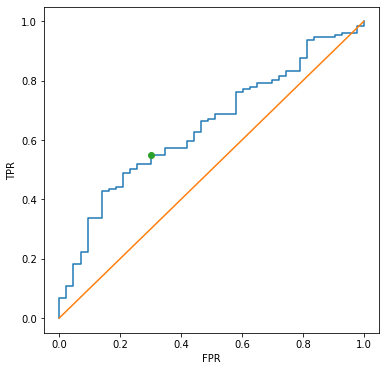

In [164]:
fpr, tpr, threshold = roc_curve(t_all, p_all)
plt.figure(1, (6,6))
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))
plt.plot(fpr[np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))],
         tpr[np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))], 'o')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [165]:
best_threshold = threshold[np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))]
print(best_threshold)

0.8214323727660308


In [166]:
np.mean((t_all == 1) == (p_all >= best_threshold))

0.5862068965517241

In [167]:
fpr[np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))]

0.3023255813953488

In [168]:
1 - fpr[np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))]

0.6976744186046512

In [175]:
tpr[np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))]

0.549618320610687

In [170]:
from sklearn.metrics import confusion_matrix

In [176]:
confusion_matrix(t_all, (p_all >= best_threshold))

array([[30, 13],
       [59, 72]])

In [177]:
roc_auc_score(t_all, p_all)

0.644771879992899

In [139]:
fold_id_table = pd.DataFrame(CN_df['PATIENTID'])
fold_id_table['test_in_SC2'] = np.zeros(len(fold_id_table), dtype=int)

In [140]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
for i, (trainval_index, test_index) in enumerate(kfold.split(CN_df)):
    fold_id_table.loc[test_index, 'test_in_SC2'] = i*np.ones(len(test_index),dtype=int)

In [141]:
fold_id_table.to_csv('SC2_fold_id_table.csv', index=False)

In [181]:
important_indexes_overall_fold = []
for importances in importances_in_folds:
    important_index = ((importances.mean(axis=0) > mean_importance_threshold) &
                       ((importances.std(axis=0)/importances.mean(axis=0) < std_per_mean_threshold)))
    important_indexes_overall_fold.append(important_index)

/home/sakai/.local/share/virtualenvs/PrecisionFDA_BrainCancer-V-Nf25ww/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/sakai/.local/share/virtualenvs/PrecisionFDA_BrainCancer-V-Nf25ww/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [182]:
pickle.dump(important_indexes_overall_fold, open('SC2_important_indexes.pkl', 'wb'))

In [145]:
important_index_overall_fold = np.array(important_indexes_overall_fold).all(axis=0)

In [149]:
keys = CN_df.keys().drop('PATIENTID')
important_CN = keys[important_index_overall_fold]

In [150]:
important_CN

Index(['4p16.1', '7p11.2', '7q11.21', '7q11.22', '7q11.23', '7q31.1', '7q36.3',
       '8q23.1', '8q23.2', '9p21.3', '10q11.23', '11p15.4', '12p13.33',
       '13q14.11', '20q11.21'],
      dtype='object')

In [184]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for i, (trainval_index, test_index) in enumerate(kfold.split(CN_df)):
    output_feature = pd.DataFrame(CN_df['PATIENTID'])
    output_feature = output_feature.iloc[trainval_index].reset_index(drop=True)
    f_x = CN_df.iloc[trainval_index].drop(['PATIENTID'], axis=1).reset_index(drop=True)
    f_x = f_x.iloc[:, important_indexes_overall_fold[i]]
    output_feature = pd.concat([output_feature, f_x], axis=1)
    output_feature.to_csv('SC2_selected_features_CV-' +str(i) + '.csv', index=False)

In [191]:
PT_df

,PATIENTID,SEX,RACE,WHO_GRADING,CANCER_TYPE
0,patient_290,,NaN,II,ASTROCYTOMA
1,patient_394,,NaN,NaN,GBM
2,patient_81,,NaN,III,ASTROCYTOMA
3,patient_307,,NaN,NaN,UNCLASSIFIED
4,patient_14,,NaN,NaN,GBM
...,...,...,...,...,...
169,patient_589,MALE,WHITE,III,ASTROCYTOMA
170,patient_283,MALE,WHITE,NaN,GBM
171,patient_25,MALE,WHITE,NaN,GBM
172,patient_658,MALE,WHITE,III,OLIGODENDROGLIOMA


In [189]:
models_PT[0][0].feature_importance('gain')

array([81.95561135, 36.26294672, 32.36026982, 42.34179201])

In [190]:
models_PT[0][1].feature_importance('gain')

array([76.33978479, 44.20827012, 36.62579827, 33.31572142])

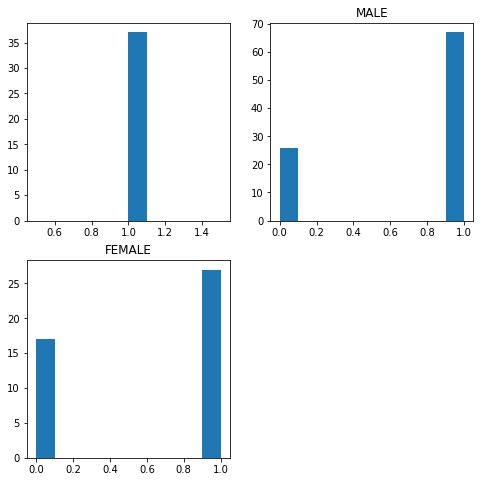

In [218]:
outcome_groupby = []
fig = plt.figure(1, (8, 8))
for i, df in enumerate(PT_df.groupby('SEX')):
    label = df[0]
    df = df[1]
    pID = df['PATIENTID']
    outcome = [int(OC_df[OC_df['PATIENTID']==i]['SURVIVAL_STATUS']) for i in pID]
    outcome_groupby.append(outcome)
    
    ax = plt.subplot2grid((2,2), (i%2,i//2))
    ax.hist(outcome)
#     ax.set_xlim(0,1)
    ax.set_title(label)

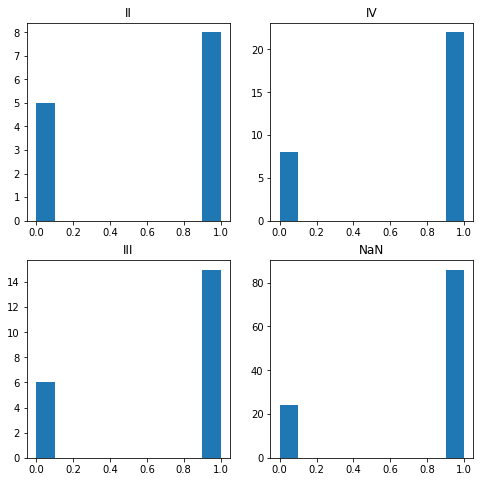

In [219]:
outcome_groupby = []
fig = plt.figure(1, (8, 8))
PT_df_fillna = PT_df.fillna('NaN').replace(' ', 'NaN')
for i, df in enumerate(PT_df_fillna.groupby('WHO_GRADING')):
    label = df[0]
    df = df[1]
    pID = df['PATIENTID']
    outcome = [int(OC_df[OC_df['PATIENTID']==i]['SURVIVAL_STATUS']) for i in pID]
    outcome_groupby.append(outcome)
    
    ax = plt.subplot2grid((2,2), (i%2,i//2))
    ax.hist(outcome)
#     ax.set_xlim(0,1)
    ax.set_title(label)

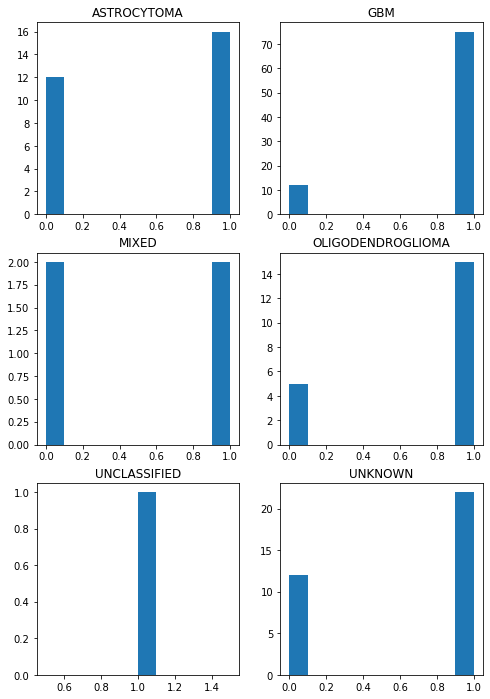

In [223]:
outcome_groupby = []
fig = plt.figure(1, (8, 12))
PT_df_fillna = PT_df.fillna('NaN').replace(' ', 'NaN')
for i, df in enumerate(PT_df_fillna.groupby('CANCER_TYPE')):
    label = df[0]
    df = df[1]
    pID = df['PATIENTID']
    outcome = [int(OC_df[OC_df['PATIENTID']==i]['SURVIVAL_STATUS']) for i in pID]
    outcome_groupby.append(outcome)
    
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    ax.hist(outcome)
#     ax.set_xlim(0,1)
    ax.set_title(label)

In [215]:
PT_df['WHO_GRADING'].drop_duplicates()

0      II
1     NaN
2     III
45     IV
Name: WHO_GRADING, dtype: object